In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA

In [3]:
# Dataset URL: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

In [4]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [5]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)

    ytrain = subset['que_paso']
    return subset, ytrain

In [6]:
data, ytrain = clean(train)

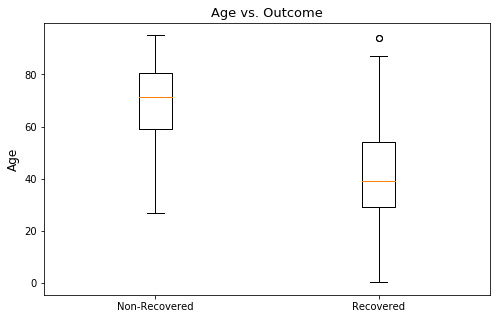

In [7]:
age_death = data['que_paso'] == 0
age_rec = data['que_paso'] == 1

xdeath = data[age_death]
xrec = data[age_rec]

age1 = xdeath['age']
age2 = xrec['age']

data2 = [age1, age2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome', fontsize = 13)

ax.boxplot(data2, labels = ['Non-Recovered', 'Recovered'])
ax.set_ylabel("Age", fontsize = 12)
plt.show()

In [8]:
xtrain = data.drop('que_paso', axis = 1)

In [9]:
clfs = {#"AdaBoost": AdaBoostClassifier(random_state = 42),
    #"Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators = 500,
                           n_jobs = -1, min_samples_leaf = 2,
                           bootstrap = True, random_state = 42),
    "Logistic Regression": LogisticRegression(solver = 'saga',
                                             random_state = 42)}
ML = list(clfs.values())
names = list(clfs.keys())

clf = ML[0].fit(xtrain, ytrain)

var_imp = clf.feature_importances_
var = ['Age', 'Sex', 'Country', 'Chronic Disease']

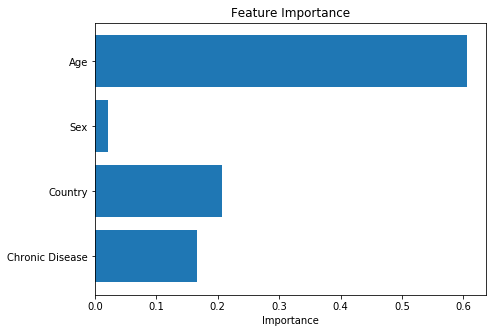

In [10]:
fig, ax = plt.subplots(figsize = (7,5))

y_pos = np.arange(len(var))

ax.barh(y_pos, var_imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance', fontsize = 10)
ax.set_title('Feature Importance', fontsize = 12)

plt.show()

In [11]:
def confusion_plot(clfs_dict, xtest, ytest):
    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
    
    for i in ML:
        disp = plot_confusion_matrix(i, xtest, ytest,
                                     display_labels = ["Not Recovered", "Recovered"],
                                     cmap = 'Blues',
                                     normalize = 'true')
        disp.ax_.set_title("Confusion Matrix: " + names[ML.index(i)])

In [35]:
def classifier(data, clfs_dict):
    selection = 0
    X = data.drop(["que_paso"], axis = 1)
    y = data.iloc[:,-1] 
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.5)
    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)

    ML = list(clfs_dict.values())
    names = list(clfs_dict.keys())
    plt.figure(figsize = (7,5))
    
    yprobList = []
    for i in ML:
        clf = i.fit(xtrain,ytrain)
        yprob = clf.predict_proba(xtest)[::,1]
        ypred = clf.predict(xtest)
        fpr, tpr, thresholds = metrics.roc_curve(ytest, yprob)
        auc = round(metrics.auc(fpr,tpr),4)
        acc = round(accuracy_score(ytest, ypred),4)
        
        print("\nThe AUC for", names[ML.index(i)], "is", auc) 
        print("The accuracy score for", names[ML.index(i)], "is", acc)
        
        plt.plot(fpr, tpr, lw = 1, label = names[ML.index(i)]) # + '. AUC: '+ str(auc))
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
        plt.xlabel("False Positive Rate", fontsize = 11)
        plt.ylabel("True Positive Rate", fontsize = 11)
        plt.legend()
        plt.title("ROC Curve", fontsize = 13)
        yprobList.append(yprob)
    return xtest, ytest, yprobList


The AUC for Random Forest is 0.9308
The accuracy score for Random Forest is 0.8665

The AUC for Logistic Regression is 0.899
The accuracy score for Logistic Regression is 0.8427


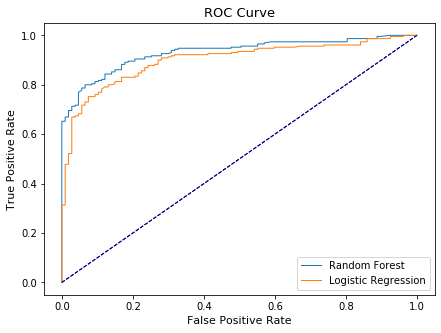

In [36]:
xtest, ytest, yprobList = classifier(data, clfs)

In [37]:
prob_df = pd.DataFrame({"Probability of Recovering by RF": yprobList[0], "Probability of Recovering by LG": yprobList[1]})

In [38]:
print("Probablity of Patients Recovering: ")
prob_df

Probablity of Patients Recovering: 


,Probability of Recovering by RF,Probability of Recovering by LG
0,0.864864,0.951688
1,0.999943,0.990992
2,0.984455,0.950386
3,0.868281,0.926526
4,0.982340,0.818390
...,...,...
332,0.070323,0.356628
333,0.090047,0.319217
334,0.955000,0.983976
335,0.043867,0.057597


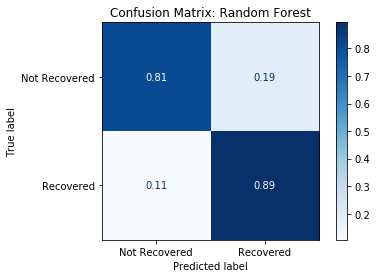

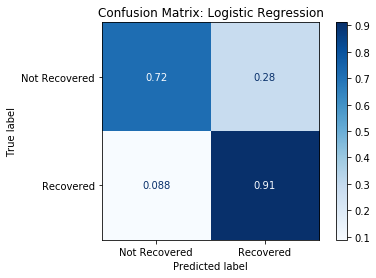

In [38]:
confusion_plot(clfs, xtest, ytest)

In [119]:
def project(data):
    zero = data['que_paso'] == 0
    one = data['que_paso'] == 1
    x0 = data[zero]
    x1 = data[one]
    
    age0 = x0.iloc[:, 0] 
    sex0 = x0.iloc[:, 1] 
    country0 = x0.iloc[:,2]
    chronic0 = x0.iloc[:,3]
    
    age1 = x1.iloc[:,0]
    sex1 = x1.iloc[:,1]
    country1 = x1.iloc[:,2]
    chronic1 = x1.iloc[:,3]
    
    # Visualizing data in higher dimension 
    fig = plt.figure(figsize = (8,6)) 
    ax = fig.add_subplot(111, projection = '3d') 
    ax.scatter(sex0, chronic0, age0, label = 'Non-Recovered')
    ax.scatter(sex1, chronic1, age1, label = 'Recovered')
    
    plt.xticks([0,1],['Male', 'Female'])
    plt.yticks([0,1],['No', 'Yes'])
    ax.set_xlabel("Sex")
    ax.set_ylabel("Chronic Disease (Y/N)")
    ax.set_zlabel("Age")
    plt.legend()
    plt.show()

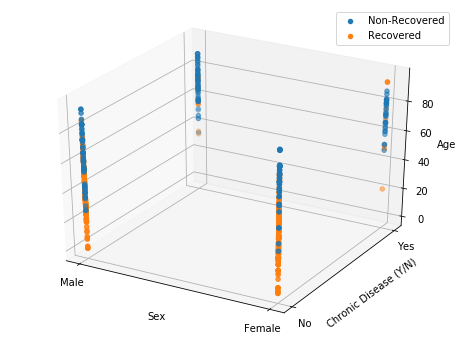

In [120]:
project(data)

In [66]:
def pca(data):
    X = data.drop(['sex','que_paso'], axis = 1)
    y = data['que_paso']
    pca = PCA(n_components = 2)
    pca_components = pca.fit_transform(X)
    return pca_components, pca.explained_variance_ratio_

In [67]:
def plot_decision_boundary(clf_dict, X, y):
    names = list(clf_dict.keys())
    methods = list(clf_dict.values())
    
    for clf in methods:
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        # Set up plotting mesh
        # Step size of the mesh
        h = .02 
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # Perform classification
        X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        # Plot the decision boundary. For that, we will assign a color to each

        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title(names[methods.index(clf)])

In [68]:
pca_components, pc = pca(data)

C:\Users\Duker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


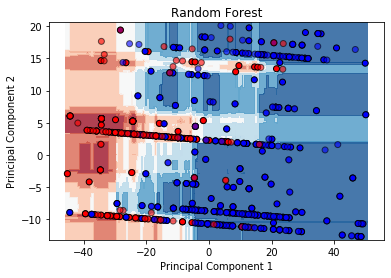

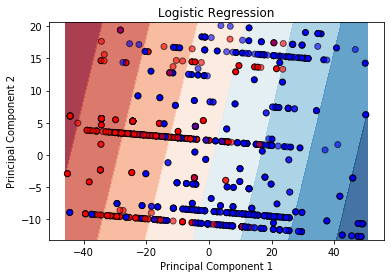

In [123]:
plot_decision_boundary(clfs, pca_components, ytrain)